<a href="https://colab.research.google.com/github/k-messick/knn/blob/main/assignment_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 3: $k$ Nearest Neighbor

**Do two questions.**

`! git clone https://github.com/ds4e/knn`

**Q0.**
1. What is the difference between regression and classification?
2. What is a confusion table? What does it help us understand about a model's performance?
3. What does the SSE quantify about a particular model?
4. What are overfitting and underfitting?
5. Why does splitting the data into training and testing sets, and choosing $k$ by evaluating accuracy or SSE on the test set, improve model performance?
6. With classification, we can report a class label as a prediction or a probability distribution over class labels. Please explain the strengths and weaknesses of each approach.

Answers
1. The difference between regression and classification is that while classification is used when predicting categorical outcomes, regression is used for predicting continuous outcomes.
2. A confusion table outlines the performance of a model. It shows the true positives, true negatives, false positives, and false negatives.
3. The SSE is a measure of how well a regression model fits the data. It is the sum of the squared differences between the actual and predicted values.
4. Overfitting is from when a model is way too intricate and learns the fluctuations in the training data. It performs well on the training data, but not so well on new data. Underfitting is when a model is too simple to identify and display the underlying patterns.
5. Splitting the data into training and testing sets improves model performance. This is because the model gets evaluated on unseen data. K is chosen by evaluating accuracy or SSE on the test set to help find the best model.
6. Reporting a class label as a prediction is easy to interpret and fast, but doesn't really convey how certain a model is about a prediction. Labeling as a probability distribution allows for more confidence in decision making, but can be hard to interpret.


**Q6.** This is a case study on $k$ nearest neighbor regression and imputation, using the `airbnb_hw.csv` data.

There are 30,478 observations, but only 22,155 ratings. We're going to build a kNN regressor to impute missing values. This is a common task, and illustrates one way you can use kNN in the future even when you have more advanced models available.

1. Load the `airbnb_hw.csv` data with Pandas. We're only going to use `Review Scores Rating`, `Price`, and `Beds`, so use `.loc` to reduce the dataframe to those variables.
2. Set use `.isnull()` to select the subset of the dataframe with missing review values. Set those aside in a different dataframe. We'll make predictions about them later.
3. Use `df = df.dropna(axis = 0, how = 'any')` to eliminate any observations with missing values/NA's from the dataframe.
4. For the complete cases, create a $k$-NN model that uses the variables `Price` and `Beds` to predict `Review Scores Rating`. How do you choose $k$? (Hint: Train/test split, iterate over reasonable values of $k$ and find a value that minimizes SSE on the test split using predictions from the training set.)
5. Predict the missing ratings.
6. Do a kernel density plot of the training ratings and the predicted missing ratings. Do they look similar or not? Explain why.

1.

In [39]:
#Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#Read in dataframe
df=pd.read_csv('/content/airbnb_hw.csv', low_memory=False)

In [4]:
#Reduce dataframe to Review Scores Rating, Price, Beds
df_airbnb = df.loc[:, ["Review Scores Rating", "Price", "Beds"]]
print(df_airbnb)

       Review Scores Rating Price  Beds
0                       NaN   145   1.0
1                       NaN    37   1.0
2                       NaN    28   1.0
3                       NaN   199   3.0
4                      96.0   549   3.0
...                     ...   ...   ...
30473                   NaN   300   5.0
30474                   NaN   125   2.0
30475                   NaN    80   1.0
30476                   NaN    35   1.0
30477                   NaN    80   1.0

[30478 rows x 3 columns]


2.

In [5]:
#Subset of the dataframe with missing review values
df_no_reviews = df_airbnb[df_airbnb["Review Scores Rating"].isnull()]
df_no_reviews

,Review Scores Rating,Price,Beds
0,NaN,145,1.0
1,NaN,37,1.0
2,NaN,28,1.0
3,NaN,199,3.0
13,NaN,68,1.0
...,...,...,...
30473,NaN,300,5.0
30474,NaN,125,2.0
30475,NaN,80,1.0
30476,NaN,35,1.0


3.

In [7]:
#Eliminate any observations with missing values
df_airbnb2 = df_airbnb.dropna(axis = 0, how = 'any')
df_airbnb2

,Review Scores Rating,Price,Beds
4,96.0,549,3.0
5,100.0,149,1.0
6,100.0,250,1.0
7,94.0,90,1.0
8,90.0,270,2.0
...,...,...,...
30332,100.0,90,1.0
30347,80.0,65,1.0
30378,100.0,55,1.0
30404,100.0,60,1.0


4.

In [8]:
#Create a  𝑘 -NN model
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [11]:
#Train/test split
X = df_airbnb2[["Price", "Beds"]] # Create feature matrix
y = df_airbnb2["Review Scores Rating"] # Create target variable vector


X['Price'] = X['Price'].str.replace(',', '').str.replace('$', '').astype(float) #Convert 'Price' column to numeric


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split the sample:

<ipython-input-11-7b85b7ee38be>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Price'] = X['Price'].str.replace(',', '').str.replace('$', '').astype(float) #Convert 'Price' column to numeric


In [16]:
#Find best k
k_bar = 50 #Number of k's to try
SSE = [] #Store the SSE here
SSE_on_train = [] #For pedogogical purposes, we'll save the training error


for k in range(k_bar):
    model = KNeighborsRegressor(n_neighbors=k+1) #Create a sk model for k
    fitted_model = model.fit(X_train,y_train) #Train the model on our data
    y_hat = fitted_model.predict(X_test) #Predict values for test set
    SSE.append(np.sum( (y_test-y_hat)**2 )) #Save the computed SSE for test set
    y_hat = fitted_model.predict(X_train) #Predict values for training set
    SSE_on_train.append(np.sum( (y_train-y_hat)**2 ) ) #Save the computed SSE

SSE_min = np.min(SSE) #Find lowest recorded SSE
min_index = np.where(SSE==SSE_min) #Find the indices of SSE that equal the minimum
k_star = min_index[0]+1 #Find the optimal value of k; why index+1?
print(k_star)

[45]


To find 𝑘  we iterated over reasonable values of  𝑘  and find a value that minimizes SSE on the test split using predictions from the training set.

5.

In [37]:
#Predict missing ratings
X_missing = df_airbnb2[["Price", "Beds"]]
X_missing['Price'] = X_missing['Price'].str.replace(',', '').str.replace('$', '').astype(float)
X_missing_scaled = scaler.transform(X_missing)

<ipython-input-37-013a01d32ddb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_missing['Price'] = X_missing['Price'].str.replace(',', '').str.replace('$', '').astype(float)


In [32]:
# Predict missing ratings using the optimal model:
df_airbnb2['Review Scores Rating'] = optimal_model.predict(X_missing_scaled)
df_airbnb2['Review Scores Rating']

,Review Scores Rating
4,95.511111
5,93.444444
6,95.333333
7,91.866667
8,93.311111
...,...
30332,91.866667
30347,90.888889
30378,90.177778
30404,91.422222


In [36]:
df_airbnb2, k_star

(       Review Scores Rating Price  Beds
 4                 95.511111   549   3.0
 5                 93.444444   149   1.0
 6                 95.333333   250   1.0
 7                 91.866667    90   1.0
 8                 93.311111   270   2.0
 ...                     ...   ...   ...
 30332             91.866667    90   1.0
 30347             90.888889    65   1.0
 30378             90.177778    55   1.0
 30404             91.422222    60   1.0
 30409             91.822222    99   1.0
 
 [22111 rows x 3 columns],
 array([45]))

6.

[Text(0.5, 1.0, 'Kernel Density Plot of Training Ratings')]

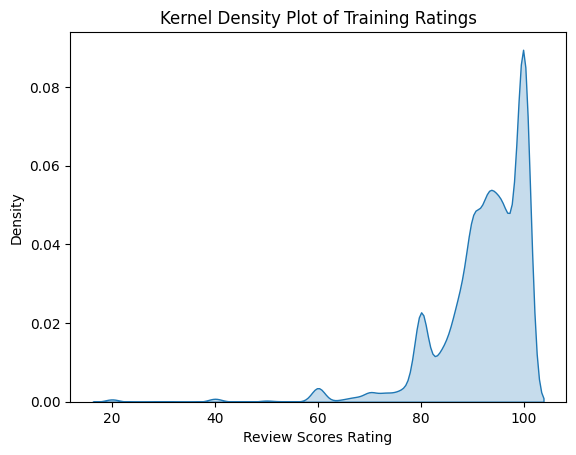

In [45]:
#Kernel density plot of the training ratings
sns.kdeplot(y_train, fill=True).set(title="Kernel Density Plot of Training Ratings")

[Text(0.5, 1.0, 'Kernal Density Plot of Predicted Missing Ratings')]

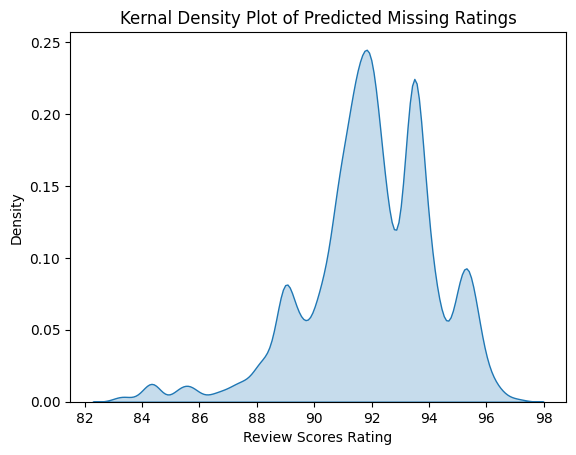

In [49]:
#Kernel density plot of the predicted missing ratings
sns.kdeplot(df_airbnb2["Review Scores Rating"], fill=True).set(title="Kernal Density Plot of Predicted Missing Ratings")

These kernal density plots do not look the same because the training set is most likely bigger (greater sample size) than the missing ratings, which is a subset. Additionally, the training data comes from actual airbnb reviews, whereas the predicted reviews are estimated from the knn model.